In [1]:
import carbonbench

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm

In [2]:
import importlib
import carbonbench
importlib.reload(carbonbench)

<module 'carbonbench' from '/users/4/rozan012/CarbonBench/carbonbench/__init__.py'>

# Process Targets

In [3]:
# 1 Process targets
# 1.1 Load targets
targets = ['GPP_NT_VUT_USTAR50', 'RECO_NT_VUT_USTAR50', 'NEE_VUT_USTAR50']
include_qc = True
test_QC_threshold = 1 # [0,1] with 1 being the highest quality data
y = carbonbench.load_targets(targets, include_qc)
y

,date,site,lat,lon,IGBP,Koppen,Koppen_short,GPP_NT_VUT_USTAR50,RECO_NT_VUT_USTAR50,NEE_VUT_USTAR50,NEE_VUT_USTAR50_QC
0,2009-01-01,FLX_AR-SLu,-33.464800,-66.459800,MF,B,BSh,8.989840,2.957700,-6.032130,0.0
1,2009-01-02,FLX_AR-SLu,-33.464800,-66.459800,MF,B,BSh,8.912250,2.977330,-5.934920,0.0
2,2009-01-03,FLX_AR-SLu,-33.464800,-66.459800,MF,B,BSh,9.356500,3.330460,-6.026040,0.0
3,2009-01-04,FLX_AR-SLu,-33.464800,-66.459800,MF,B,BSh,9.826600,3.794460,-6.032130,0.0
4,2009-01-05,FLX_AR-SLu,-33.464800,-66.459800,MF,B,BSh,9.727970,3.793040,-5.934920,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1435909,2023-12-27,JPX_JP-Tmd,42.735911,141.523147,DBF,D,Dfb,1.013866,0.617556,-0.396310,0.0
1435910,2023-12-28,JPX_JP-Tmd,42.735911,141.523147,DBF,D,Dfb,0.738017,0.734304,-0.003712,0.0
1435911,2023-12-29,JPX_JP-Tmd,42.735911,141.523147,DBF,D,Dfb,0.744890,0.765398,0.020508,0.0
1435912,2023-12-30,JPX_JP-Tmd,42.735911,141.523147,DBF,D,Dfb,0.470808,0.907578,0.436770,0.0


In [4]:
# 1.2 Explore targets
print(f"Total number of sites: {y.site.nunique()}")
print(f"Total number of samples: {len(y)}, QC∈[0,1]")
if include_qc:
    print(f"Total number of top-quality samples: {len(y[y.NEE_VUT_USTAR50_QC==1])}, QC=1")

Total number of sites: 567
Total number of samples: 1304309, QC∈[0,1]
Total number of top-quality samples: 553467, QC=1


In [6]:
# 1.3 Split targets on train and test (15 random days for fine-tuning)
split_type = 'few-shot' 
y_train, y_test, y_finetune = carbonbench.split_targets(y, split_type, verbose=True, plot=False)

Train sites: 438, Test sites: 129

Koppen balance:
        overall  test
Koppen               
A            19     4
B            55    13
C           194    45
D           284    62
E            15     5


# Process Features

In [7]:
modis = carbonbench.load_modis()

era_feature_set = 'minimal' # minimal (6), stanard (36), full (150)
era = carbonbench.load_era(era_feature_set)

train, val, finetune, test, x_scaler, y_scaler = carbonbench.join_features_finetune(y_train, y_finetune, y_test, modis, era, scale=True)

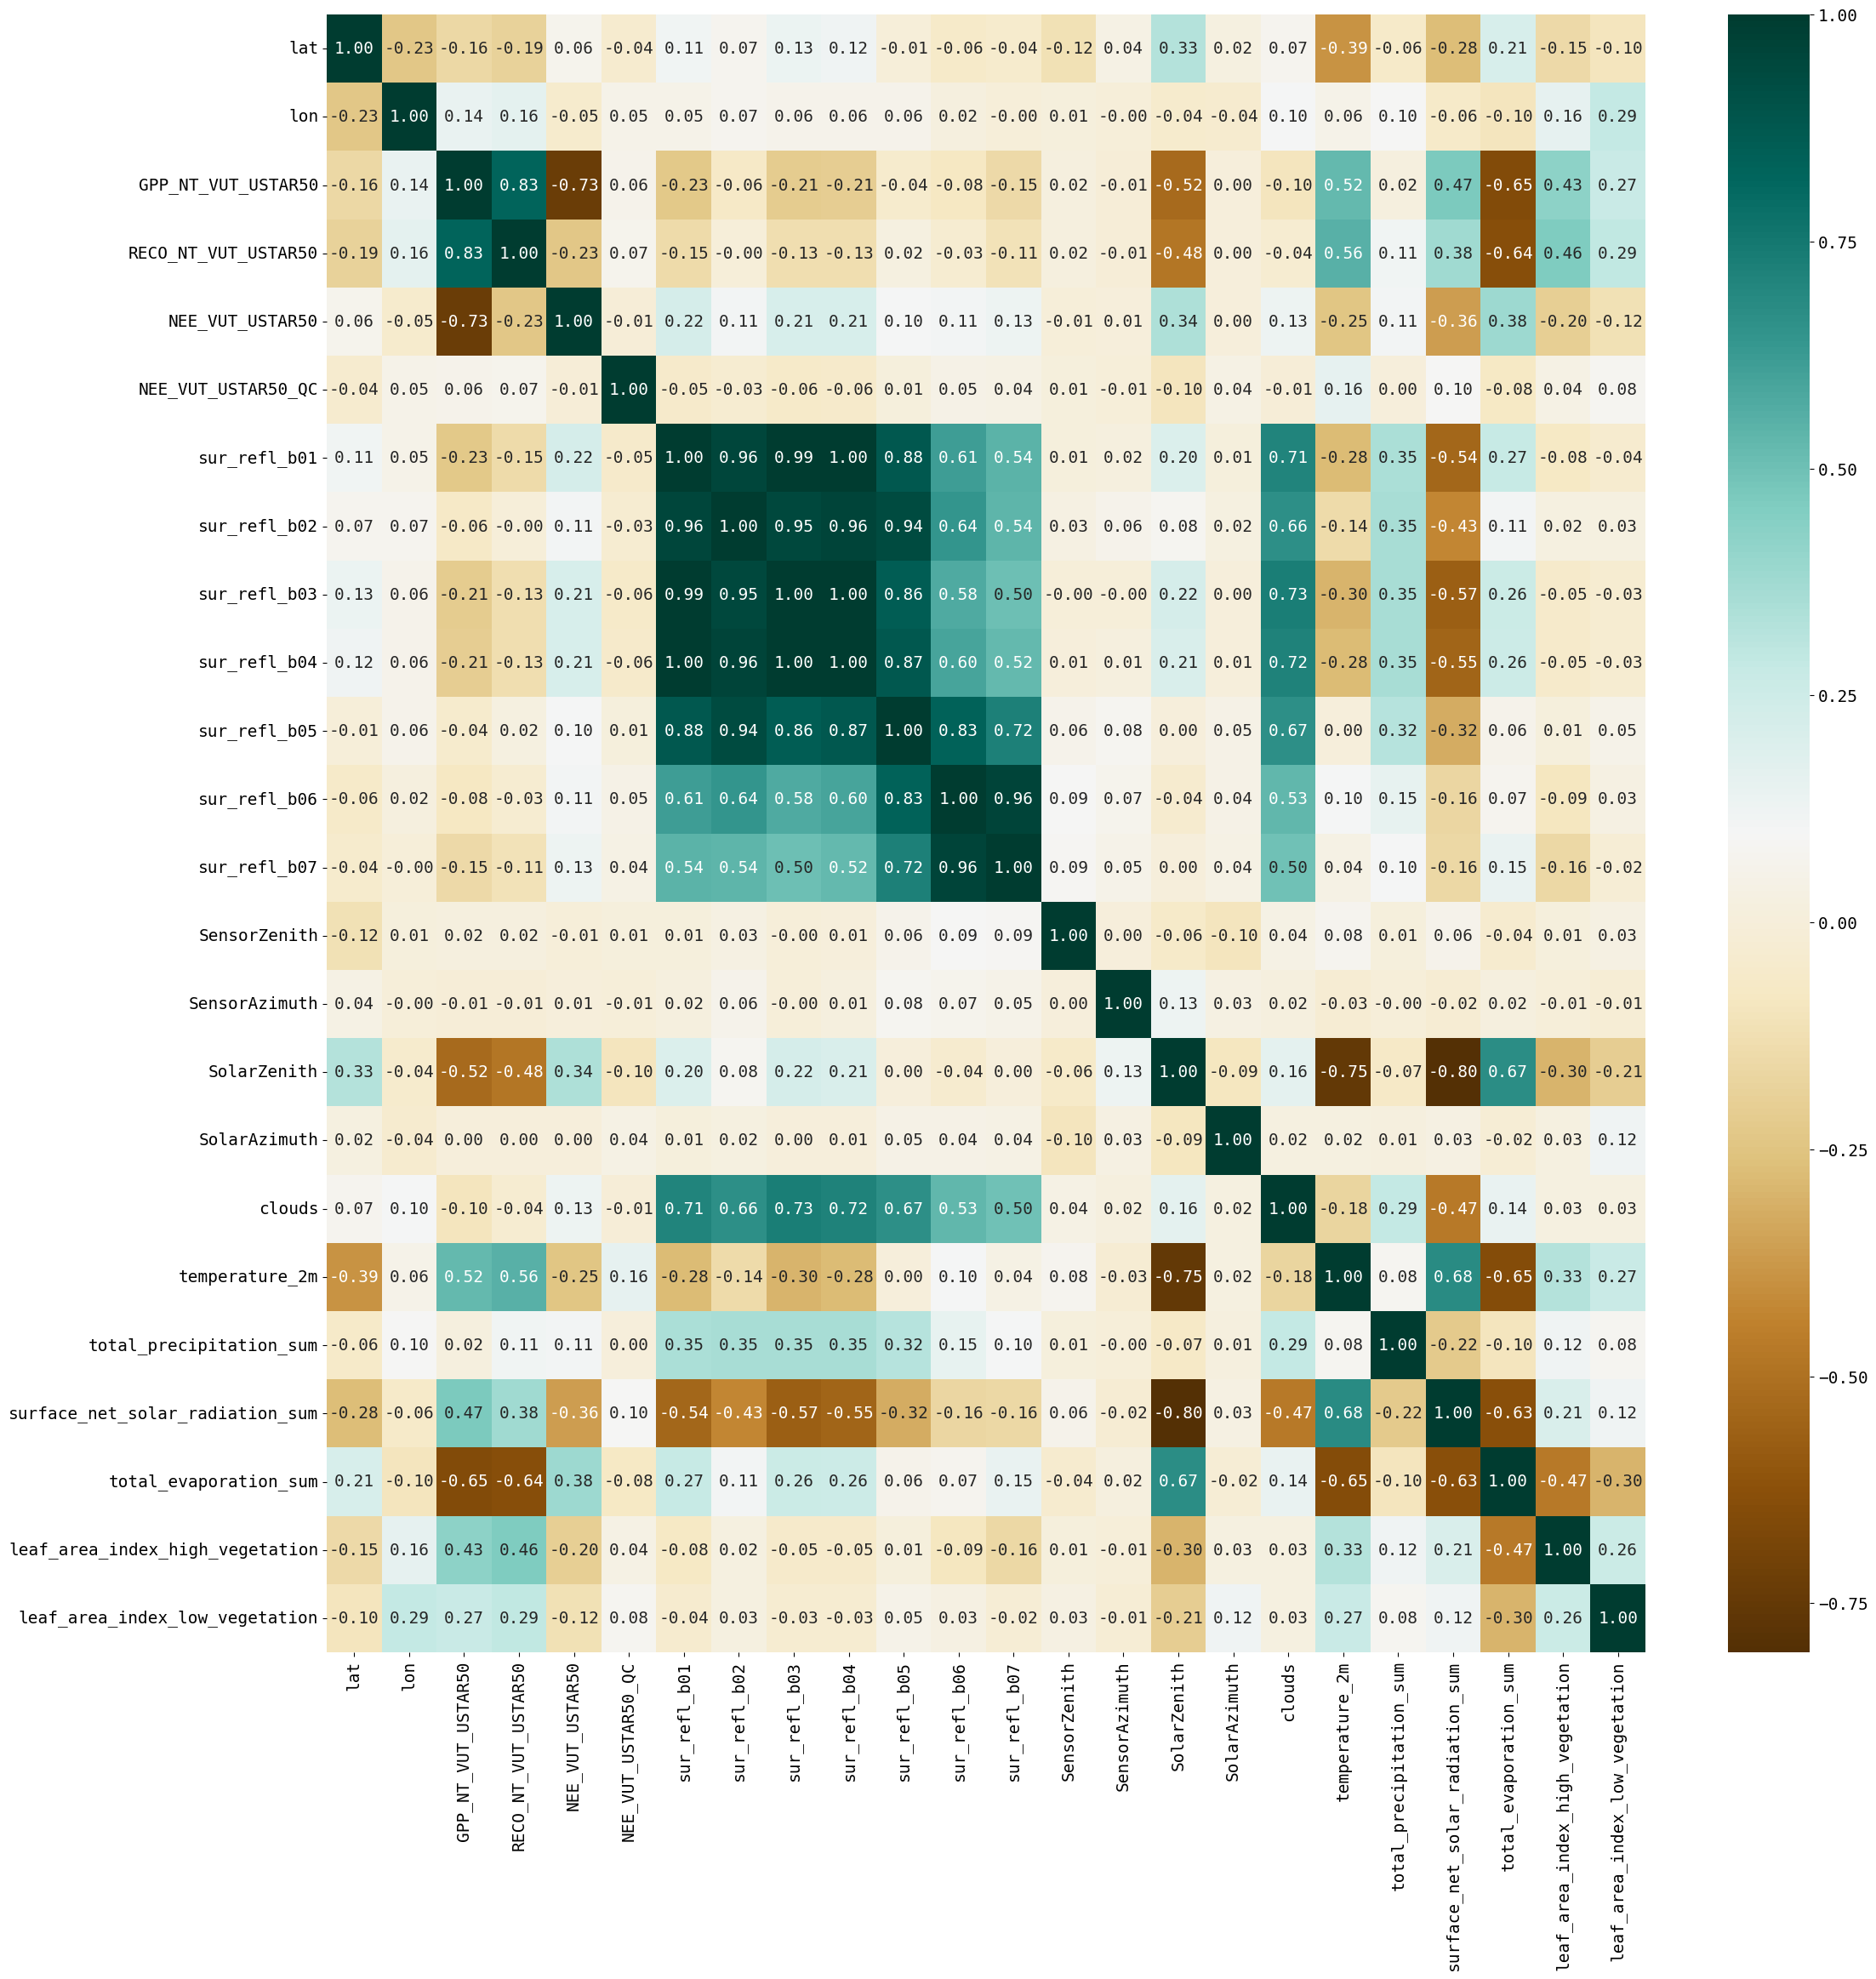

In [17]:
carbonbench.plot_feature_heatmap(train)

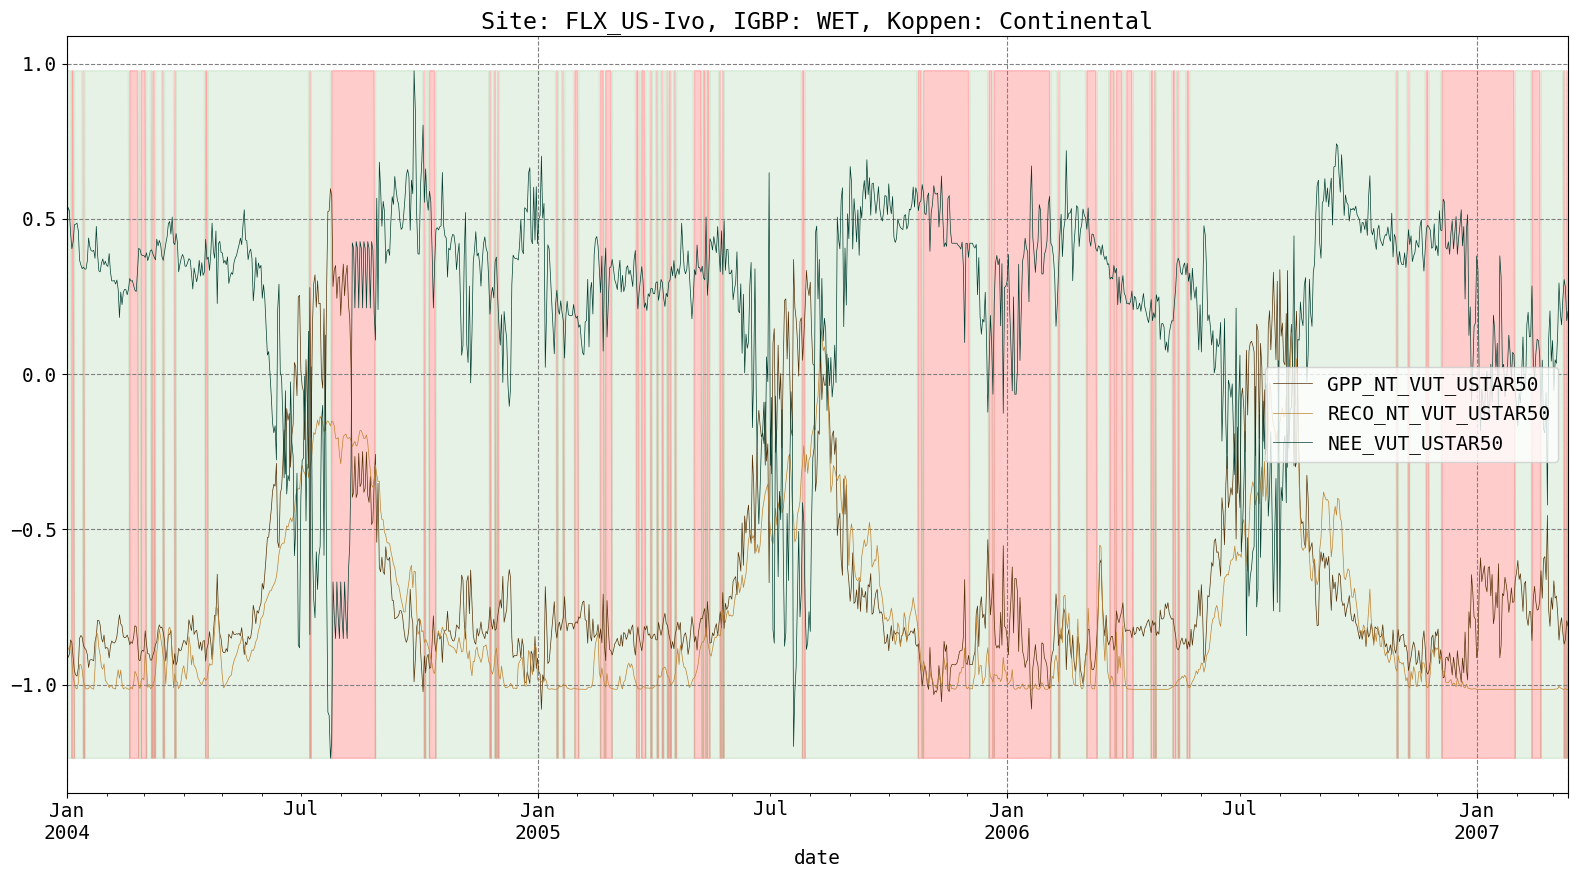

In [61]:
carbonbench.plot_site_ts(train, targets, include_qc, qc_threshold=0.75, site_name='random')

In [8]:
'''Sliding Window (for time series modeling in torch)'''
batch_size = 32
window_size = 45
stride = 15
num_workers = 0 # parallelize data loading

train_hist = carbonbench.historical_cache(train, era, modis, x_scaler, window_size)
train_dataset = carbonbench.SlidingWindowDataset(train_hist, targets, include_qc, window_size=window_size, stride=stride, cat_features=['IGBP', 'Koppen', 'Koppen_short'])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

finetune_hist = carbonbench.historical_cache(finetune, era, modis, x_scaler, window_size)
finetune_dataset = carbonbench.SlidingWindowDataset(finetune_hist, targets, include_qc, window_size=window_size, stride=1, encoders=train_dataset.encoders,
                                                    cat_features=['IGBP', 'Koppen', 'Koppen_short'])
finetune_loader = DataLoader(finetune_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_hist = carbonbench.historical_cache(val, era, modis, x_scaler, window_size)
val_dataset = carbonbench.SlidingWindowDataset(val_hist, targets, include_qc, window_size=window_size, stride=stride, encoders=train_dataset.encoders,
                                               cat_features=['IGBP', 'Koppen', 'Koppen_short'])
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [9]:
'''Tabular Processing (RF, XGBoost, etc.)'''
# to use tree-based model in a fine-tune settting -- stack train and fine-tune data
train_stack = pd.concat([train, finetune], axis=0).reset_index(drop=True)

X_train_tab, y_train_tab, y_train_qc_tab = carbonbench.tabular(train_stack, targets, include_qc, cat_features=['IGBP', 'Koppen', 'Koppen_short'])
X_val_tab, y_val_tab, y_val_qc_tab = carbonbench.tabular(val, targets, include_qc, cat_features=['IGBP', 'Koppen', 'Koppen_short'])
X_test_tab, y_test_tab, y_test_qc_tab = carbonbench.tabular(test, targets, include_qc, test_QC_threshold, cat_features=['IGBP', 'Koppen', 'Koppen_short'])

# TODO:
- [x] Add koppen short
- [x] Sliding window pipeline
    - [x] One-hot for Koppen and IGBP
- [x] Process tabular
- [x] LSTM baseline
- [x] Evaluation tools and metrics
- [ ] Results visuals

# Baselines

In [58]:
results = {}

## Tree Models

In [59]:
import xgboost as xgb

In [60]:
dtrain = xgb.DMatrix(X_train_tab.drop('site', axis=1), label=y_train_tab, weight=y_train_qc_tab.clip(1e-2, 1), enable_categorical=True)
dval = xgb.DMatrix(X_val_tab.drop('site', axis=1), label=y_val_tab, enable_categorical=True)

params = {
    'colsample_bynode': 1,
    'learning_rate': 0.05,
    'max_depth': 10,
    'num_parallel_tree': 1,
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'min_child_weight': 5
}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dval, 'validation')],
    verbose_eval=50,
)

[0]	validation-rmse:0.97127
[50]	validation-rmse:0.60219
[100]	validation-rmse:0.58687
[150]	validation-rmse:0.58418
[200]	validation-rmse:0.58260
[232]	validation-rmse:0.58203


In [61]:
results['XGBoost'] = carbonbench.eval_tree_model(X_test_tab, y_test_tab, targets, model, y_scaler, method='xgb')

			R2	RMSE	MAPE
GPP_NT_VUT_USTAR50:	0.42	1.28	1.52
RECO_NT_VUT_USTAR50:	0.29	0.69	0.48
NEE_VUT_USTAR50:	0.24	1.37	5.48


# PyTorch

In [10]:
test_hist = carbonbench.historical_cache(test, era, modis, x_scaler, window_size)
test_dataset = carbonbench.SlidingWindowDataset(test_hist, targets, include_qc, window_size=window_size, QC_threshold=test_QC_threshold, stride=1, cat_features=['IGBP', 'Koppen', 'Koppen_short'],
                                    encoders=train_dataset.encoders)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

## Train one model

### Pre-training

In [13]:
input_dynamic_channels = 20 # 12 - MODIS + lat + lon + ERA (6/36/150)
input_static_channels = 39
hidden_dim = 128
output_channels = len(targets)
dropout = 0.2
nhead = 4
layers = 1
tf_layers = 4
num_epoch = 25
device = 'cpu'

In [14]:
model = carbonbench.ctlstm(input_dynamic_channels, input_static_channels, hidden_dim, output_channels, dropout, layers).to(device)
architecture = model.__class__.__name__

In [15]:
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [16]:
best = np.inf
for epoch in tqdm(range(num_epoch)):
    model.train()
    for x, x_static, y in train_loader:
        x, x_static, y = x.to(device), x_static.to(device), y.squeeze().to(device)
        optimizer.zero_grad()
        if architecture in ['lstm', 'gru']:
            pred = model(x)
        else:
            pred = model(x, x_static)
        
        error = criterion(pred[:,-stride:, :], y[:,-stride:,:3].to(device))
            
        error.backward()
        optimizer.step()
    scheduler.step()
    
    if epoch % 5 == 0:
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for x, x_static, y in val_loader:
                x, x_static, y = x.to(device), x_static.to(device), y.squeeze().to(device)
                if architecture in ['lstm', 'gru']:
                    preds = model(x)
                else:
                    preds = model(x, x_static)
                val_preds.append(preds.detach().cpu())
                val_true.append(y.detach().cpu())
        val_preds = torch.cat(val_preds).squeeze()
        val_true = torch.cat(val_true).squeeze()
        
        test_loss = criterion(val_preds.to(device)[:,-stride:,:], val_true[:,-stride:, :3].to(device))

        best_old = best
        best = min(test_loss, best)
        if abs(best) < best_old:
            best_model = model.state_dict()
#             torch.save(model.state_dict(), f'{model_folder}/model_state.pth')
        print(f'Validation RMSE: {test_loss:0.3f}')
model.load_state_dict(best_model) # load best model

  4%|█▌                                      | 1/25 [03:13<1:17:14, 193.11s/it]

Validation RMSE: 0.405


 24%|██████████                                | 6/25 [16:52<53:24, 168.67s/it]

Validation RMSE: 0.360


 44%|██████████████████                       | 11/25 [29:20<36:03, 154.53s/it]

Validation RMSE: 0.359


 64%|██████████████████████████▏              | 16/25 [41:16<21:58, 146.46s/it]

Validation RMSE: 0.364


 84%|███████████████████████████████████▎      | 21/25 [49:09<06:11, 92.83s/it]

Validation RMSE: 0.365


100%|█████████████████████████████████████████| 25/25 [56:39<00:00, 136.00s/it]


<All keys matched successfully>

#### Fine-tuning

In [72]:
x.shape

torch.Size([32, 45, 20])

In [73]:
x_static.shape

torch.Size([32, 45, 41])

In [18]:
optimizer = optim.Adam(model.parameters(), lr=1e-4) 

best = np.inf
for epoch in tqdm(range(num_epoch)):
    model.train()
    for x, x_static, y in finetune_loader:
        x, x_static, y = x.to(device), x_static.to(device), y.squeeze().to(device)
        optimizer.zero_grad()
        if architecture in ['lstm', 'gru']:
            pred = model(x)
        else:
            pred = model(x, x_static)
        
        error = criterion(pred[:,-1:, :], y[:,:3].to(device))
            
        error.backward()
        optimizer.step()
    
    if epoch % 5 == 0:
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for x, x_static, y in val_loader:
                x, x_static, y = x.to(device), x_static.to(device), y.squeeze().to(device)
                if architecture in ['lstm', 'gru']:
                    preds = model(x)
                else:
                    preds = model(x, x_static)
                val_preds.append(preds.detach().cpu())
                val_true.append(y.detach().cpu())
        val_preds = torch.cat(val_preds).squeeze()
        val_true = torch.cat(val_true).squeeze()
        
        test_loss = criterion(val_preds.to(device)[:,-stride:,:], val_true[:,-stride:, :3].to(device))

        best_old = best
        best = min(test_loss, best)
        if abs(best) < best_old:
            best_model = model.state_dict()
#             torch.save(model.state_dict(), f'{model_folder}/model_state.pth')
        print(f'Validation RMSE: {test_loss:0.3f}')
model.load_state_dict(best_model) # load best model

  4%|█▋                                         | 1/25 [00:11<04:24, 11.04s/it]

Validation RMSE: 0.376


 24%|██████████▎                                | 6/25 [00:30<01:47,  5.68s/it]

Validation RMSE: 0.501


 44%|██████████████████▍                       | 11/25 [00:50<01:15,  5.42s/it]

Validation RMSE: 0.579


 64%|██████████████████████████▉               | 16/25 [01:22<01:18,  8.72s/it]

Validation RMSE: 0.626


 84%|███████████████████████████████████▎      | 21/25 [02:05<00:40, 10.23s/it]

Validation RMSE: 0.661


100%|██████████████████████████████████████████| 25/25 [02:14<00:00,  5.36s/it]


<All keys matched successfully>

In [69]:
results[architecture] = carbonbench.eval_nn_model(test_dataset, test, targets, model, architecture, device, y_scaler, window_size)

			R2	RMSE	MAPE
GPP_NT_VUT_USTAR50:	0.35	2.32	0.97
RECO_NT_VUT_USTAR50:	0.3	1.62	0.62
NEE_VUT_USTAR50:	0.11	2.05	8.72


# Train Many Models

In [27]:
input_dynamic_channels = 20 # 12 - MODIS + lat + lon + ERA (6/36/150)
input_static_channels = 39
hidden_dim = 128
output_channels = len(targets)
dropout = 0.2
nhead = 4
layers = 1
tf_layers = 4
num_epoch = 25
device = 'cuda'

base_args = {
    'input_dynamic_channels': input_dynamic_channels,
    'hidden_dim': hidden_dim,
    'output_channels': output_channels,
    'dropout': dropout,
}

In [50]:
for model_class in [carbonbench.lstm, carbonbench.ctlstm, carbonbench.gru,  carbonbench.ctgru, carbonbench.transformer]: 
    architecture = model_class.__name__
    
    kwargs = base_args.copy()
    if architecture in ['lstm', 'gru']:
        kwargs['layers'] = layers
    else:
        kwargs['input_static_channels'] = input_static_channels
        
    if architecture=='transformer':
        kwargs['nhead'] = nhead
        kwargs['num_layers'] = tf_layers
        kwargs['seq_len'] = window_size
    else:
        kwargs['layers'] = layers
        
    model = model_class(**kwargs).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3) 
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    
    best = np.inf
    for epoch in tqdm(range(num_epoch)):
        model.train()
        for x, x_static, y in train_loader:
            x, x_static, y = x.to(device), x_static.to(device), y.squeeze().to(device)
            optimizer.zero_grad()
            if architecture in ['lstm', 'gru']:
                pred = model(x)
            else:
                pred = model(x, x_static)

            error = criterion(pred[:,-stride:, :], y[:,-stride:,:3].to(device))

            error.backward()
            optimizer.step()
        scheduler.step()

        if epoch % 5 == 0:
            model.eval()
            val_preds = []
            val_true = []
            with torch.no_grad():
                for x, x_static, y in val_loader:
                    x, x_static, y = x.to(device), x_static.to(device), y.squeeze().to(device)
                    if architecture in ['lstm', 'gru']:
                        preds = model(x)
                    else:
                        preds = model(x, x_static)
                    val_preds.append(preds.detach().cpu())
                    val_true.append(y.detach().cpu())
            val_preds = torch.cat(val_preds).squeeze()
            val_true = torch.cat(val_true).squeeze()

            test_loss = criterion(val_preds.to(device)[:,-stride:,:], val_true[:,-stride:, :3].to(device))

            best_old = best
            best = min(test_loss, best)
            if abs(best) < best_old:
                best_model = model.state_dict()
                #torch.save(model.state_dict(), f'{model_folder}/model_state.pth')
            print(f'Validation RMSE: {test_loss:0.3f}')
    print("="*10, f"{architecture} Summary", "="*10)
    model.load_state_dict(best_model) # load best model
    results[architecture] = carbonbench.eval_nn_model(test_dataset, test, targets, model, architecture, device, y_scaler, window_size)

  4%|█▊                                          | 1/25 [00:21<08:38, 21.59s/it]

Validation RMSE: 0.454


 24%|██████████▌                                 | 6/25 [01:54<06:07, 19.35s/it]

Validation RMSE: 0.393


 44%|██████████████████▉                        | 11/25 [03:27<04:26, 19.04s/it]

Validation RMSE: 0.387


 64%|███████████████████████████▌               | 16/25 [04:59<02:51, 19.08s/it]

Validation RMSE: 0.379


 84%|████████████████████████████████████       | 21/25 [06:31<01:16, 19.01s/it]

Validation RMSE: 0.385


100%|███████████████████████████████████████████| 25/25 [07:42<00:00, 18.51s/it]


========== lstm Summary ==========
			R2	RMSE	MAPE
GPP_NT_VUT_USTAR50:	0.44	2.12	0.92
RECO_NT_VUT_USTAR50:	0.35	1.59	0.72
NEE_VUT_USTAR50:	0.24	1.7	6.66


  4%|█▊                                          | 1/25 [00:21<08:30, 21.26s/it]

Validation RMSE: 0.396


 24%|██████████▌                                 | 6/25 [01:52<06:01, 19.02s/it]

Validation RMSE: 0.346


 44%|██████████████████▉                        | 11/25 [03:23<04:24, 18.87s/it]

Validation RMSE: 0.354


 64%|███████████████████████████▌               | 16/25 [04:55<02:49, 18.88s/it]

Validation RMSE: 0.353


 84%|████████████████████████████████████       | 21/25 [06:27<01:15, 18.90s/it]

Validation RMSE: 0.367


100%|███████████████████████████████████████████| 25/25 [07:37<00:00, 18.29s/it]


========== ctlstm Summary ==========
			R2	RMSE	MAPE
GPP_NT_VUT_USTAR50:	0.49	1.95	0.81
RECO_NT_VUT_USTAR50:	0.39	1.42	0.61
NEE_VUT_USTAR50:	0.29	1.62	6.36


  4%|█▊                                          | 1/25 [00:21<08:37, 21.55s/it]

Validation RMSE: 0.452


 24%|██████████▌                                 | 6/25 [01:53<06:04, 19.17s/it]

Validation RMSE: 0.408


 44%|██████████████████▉                        | 11/25 [03:24<04:22, 18.73s/it]

Validation RMSE: 0.397


 64%|███████████████████████████▌               | 16/25 [04:54<02:48, 18.67s/it]

Validation RMSE: 0.423


 84%|████████████████████████████████████       | 21/25 [06:25<01:14, 18.64s/it]

Validation RMSE: 0.404


100%|███████████████████████████████████████████| 25/25 [07:36<00:00, 18.25s/it]


========== gru Summary ==========
			R2	RMSE	MAPE
GPP_NT_VUT_USTAR50:	0.42	2.14	0.99
RECO_NT_VUT_USTAR50:	0.34	1.58	0.73
NEE_VUT_USTAR50:	0.23	1.72	6.65


  4%|█▊                                          | 1/25 [00:21<08:37, 21.58s/it]

Validation RMSE: 0.440


 24%|██████████▌                                 | 6/25 [01:53<06:01, 19.05s/it]

Validation RMSE: 0.360


 44%|██████████████████▉                        | 11/25 [03:24<04:22, 18.75s/it]

Validation RMSE: 0.362


 64%|███████████████████████████▌               | 16/25 [04:55<02:48, 18.75s/it]

Validation RMSE: 0.367


 84%|████████████████████████████████████       | 21/25 [06:25<01:14, 18.70s/it]

Validation RMSE: 0.375


100%|███████████████████████████████████████████| 25/25 [07:36<00:00, 18.24s/it]


========== ctgru Summary ==========
			R2	RMSE	MAPE
GPP_NT_VUT_USTAR50:	0.47	2.06	0.92
RECO_NT_VUT_USTAR50:	0.38	1.44	0.63
NEE_VUT_USTAR50:	0.26	1.67	6.45


  4%|█▊                                          | 1/25 [00:27<10:53, 27.24s/it]

Validation RMSE: 0.417


 24%|██████████▌                                 | 6/25 [02:27<07:53, 24.90s/it]

Validation RMSE: 0.379


 44%|██████████████████▉                        | 11/25 [04:28<05:46, 24.78s/it]

Validation RMSE: 0.365


 64%|███████████████████████████▌               | 16/25 [06:28<03:42, 24.68s/it]

Validation RMSE: 0.381


 84%|████████████████████████████████████       | 21/25 [08:29<01:38, 24.71s/it]

Validation RMSE: 0.384


100%|███████████████████████████████████████████| 25/25 [10:02<00:00, 24.10s/it]


========== transformer Summary ==========
			R2	RMSE	MAPE
GPP_NT_VUT_USTAR50:	0.45	2.1	0.87
RECO_NT_VUT_USTAR50:	0.34	1.63	0.7
NEE_VUT_USTAR50:	0.26	1.65	6.4


# Eval All Models by site, IGBP, and Koppen

In [51]:
metrics = ['RMSE', 'R2', 'MAPE']

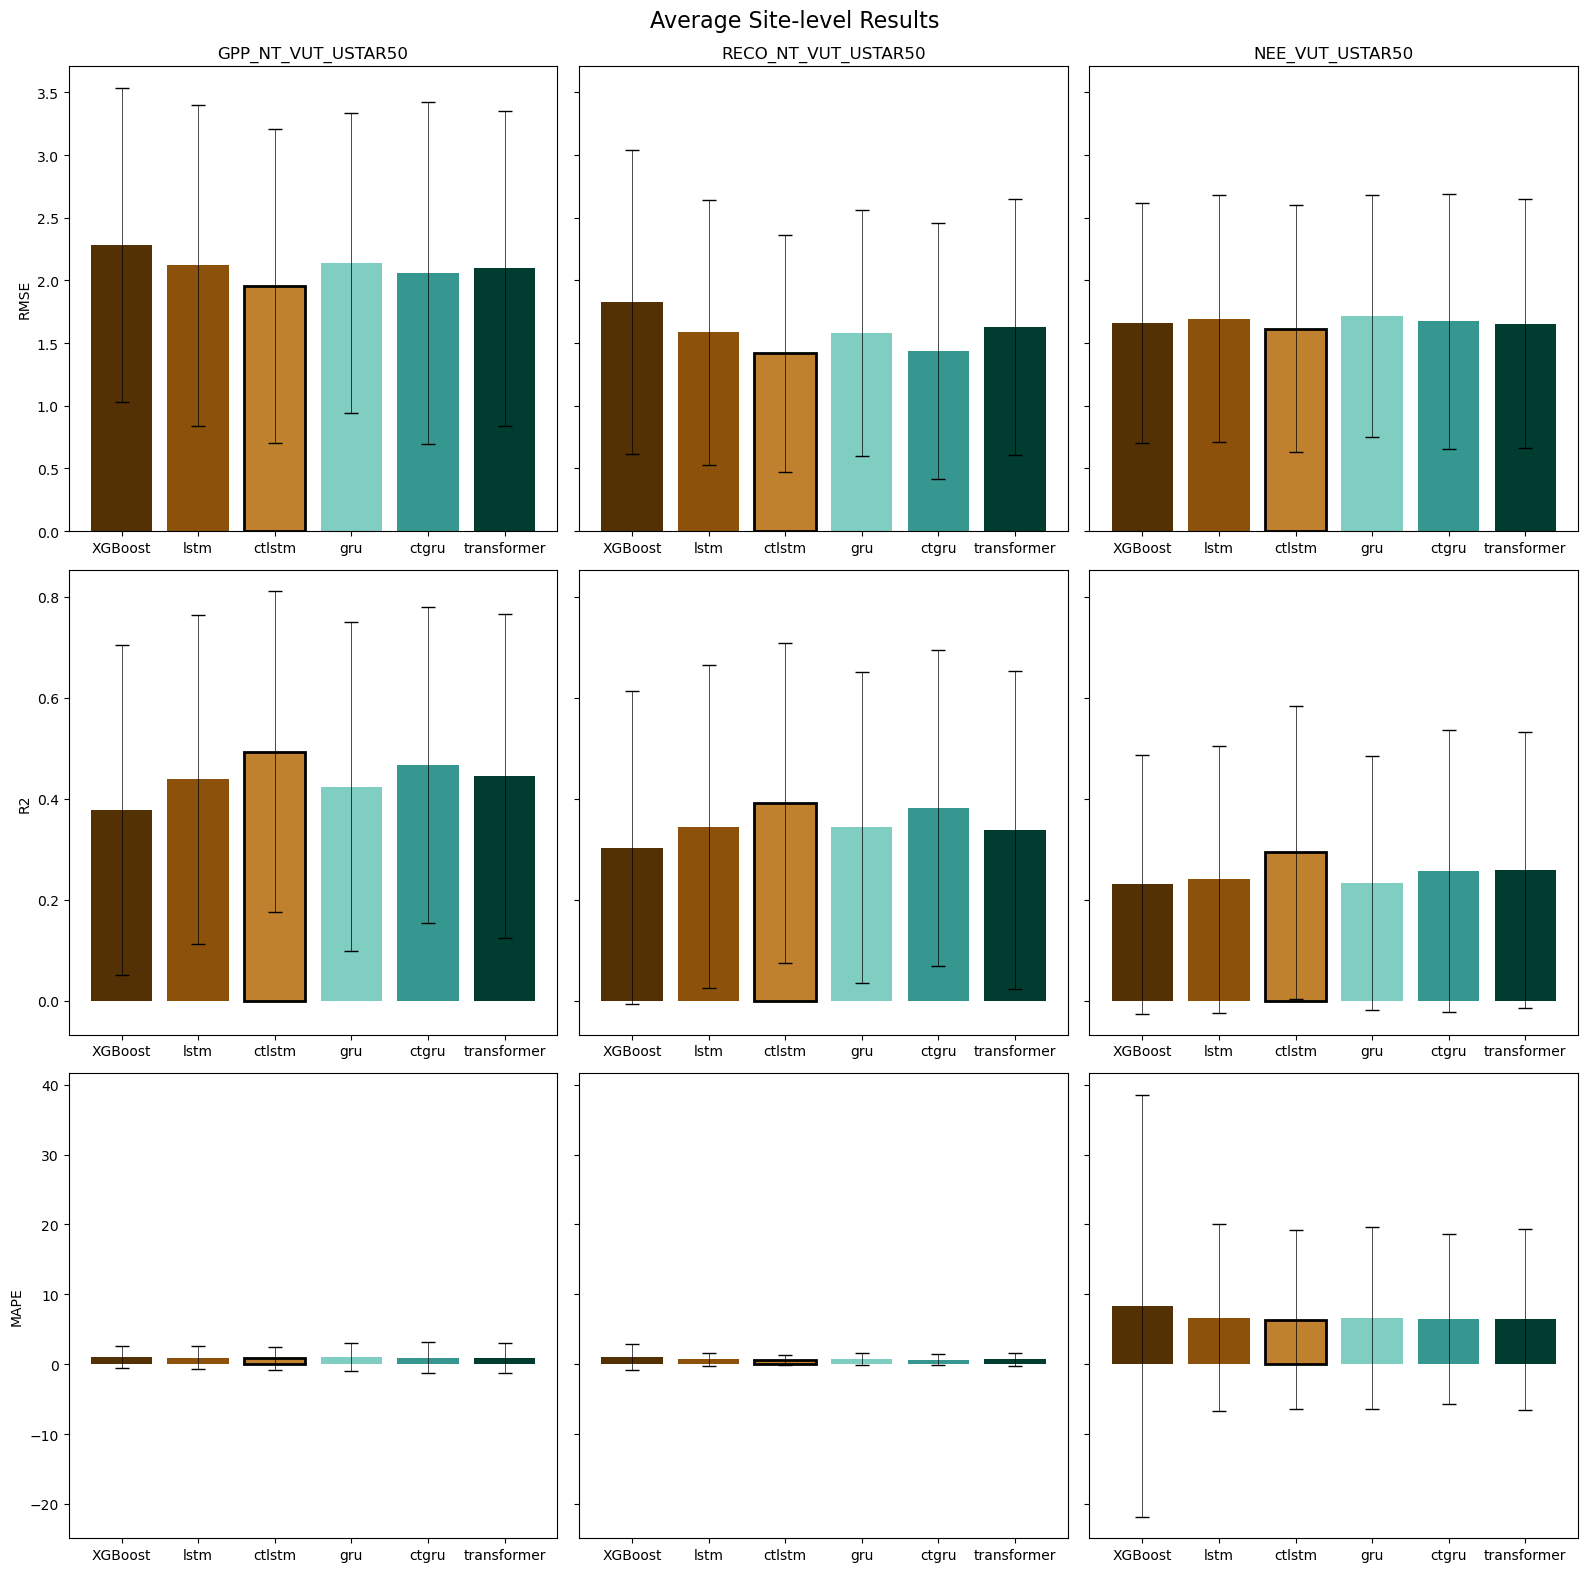

In [52]:
carbonbench.plot_bars(results, metrics, targets)

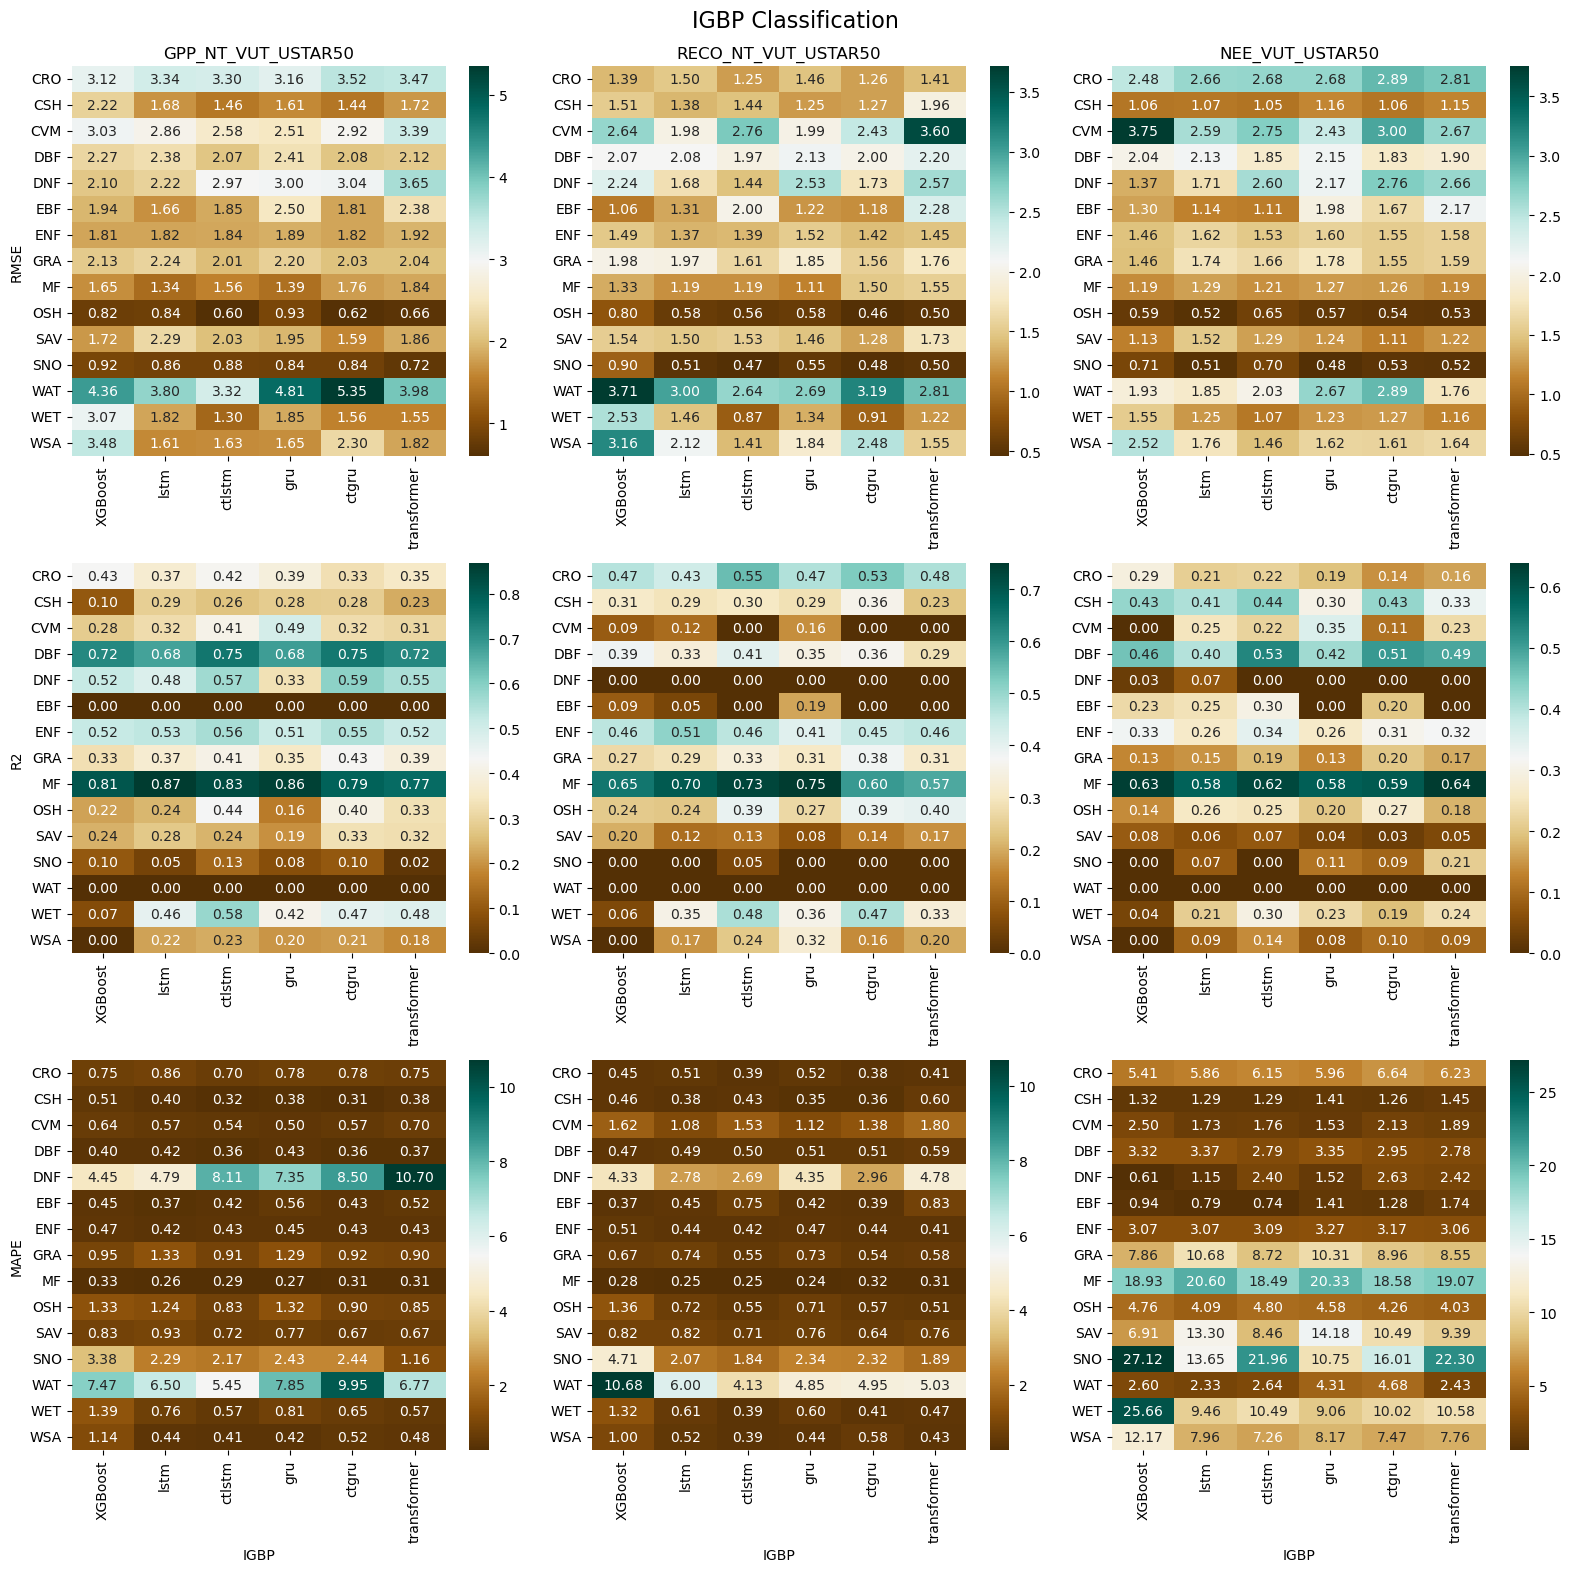

In [53]:
carbonbench.plot_heatmap(results, metrics, targets, classification='IGBP')

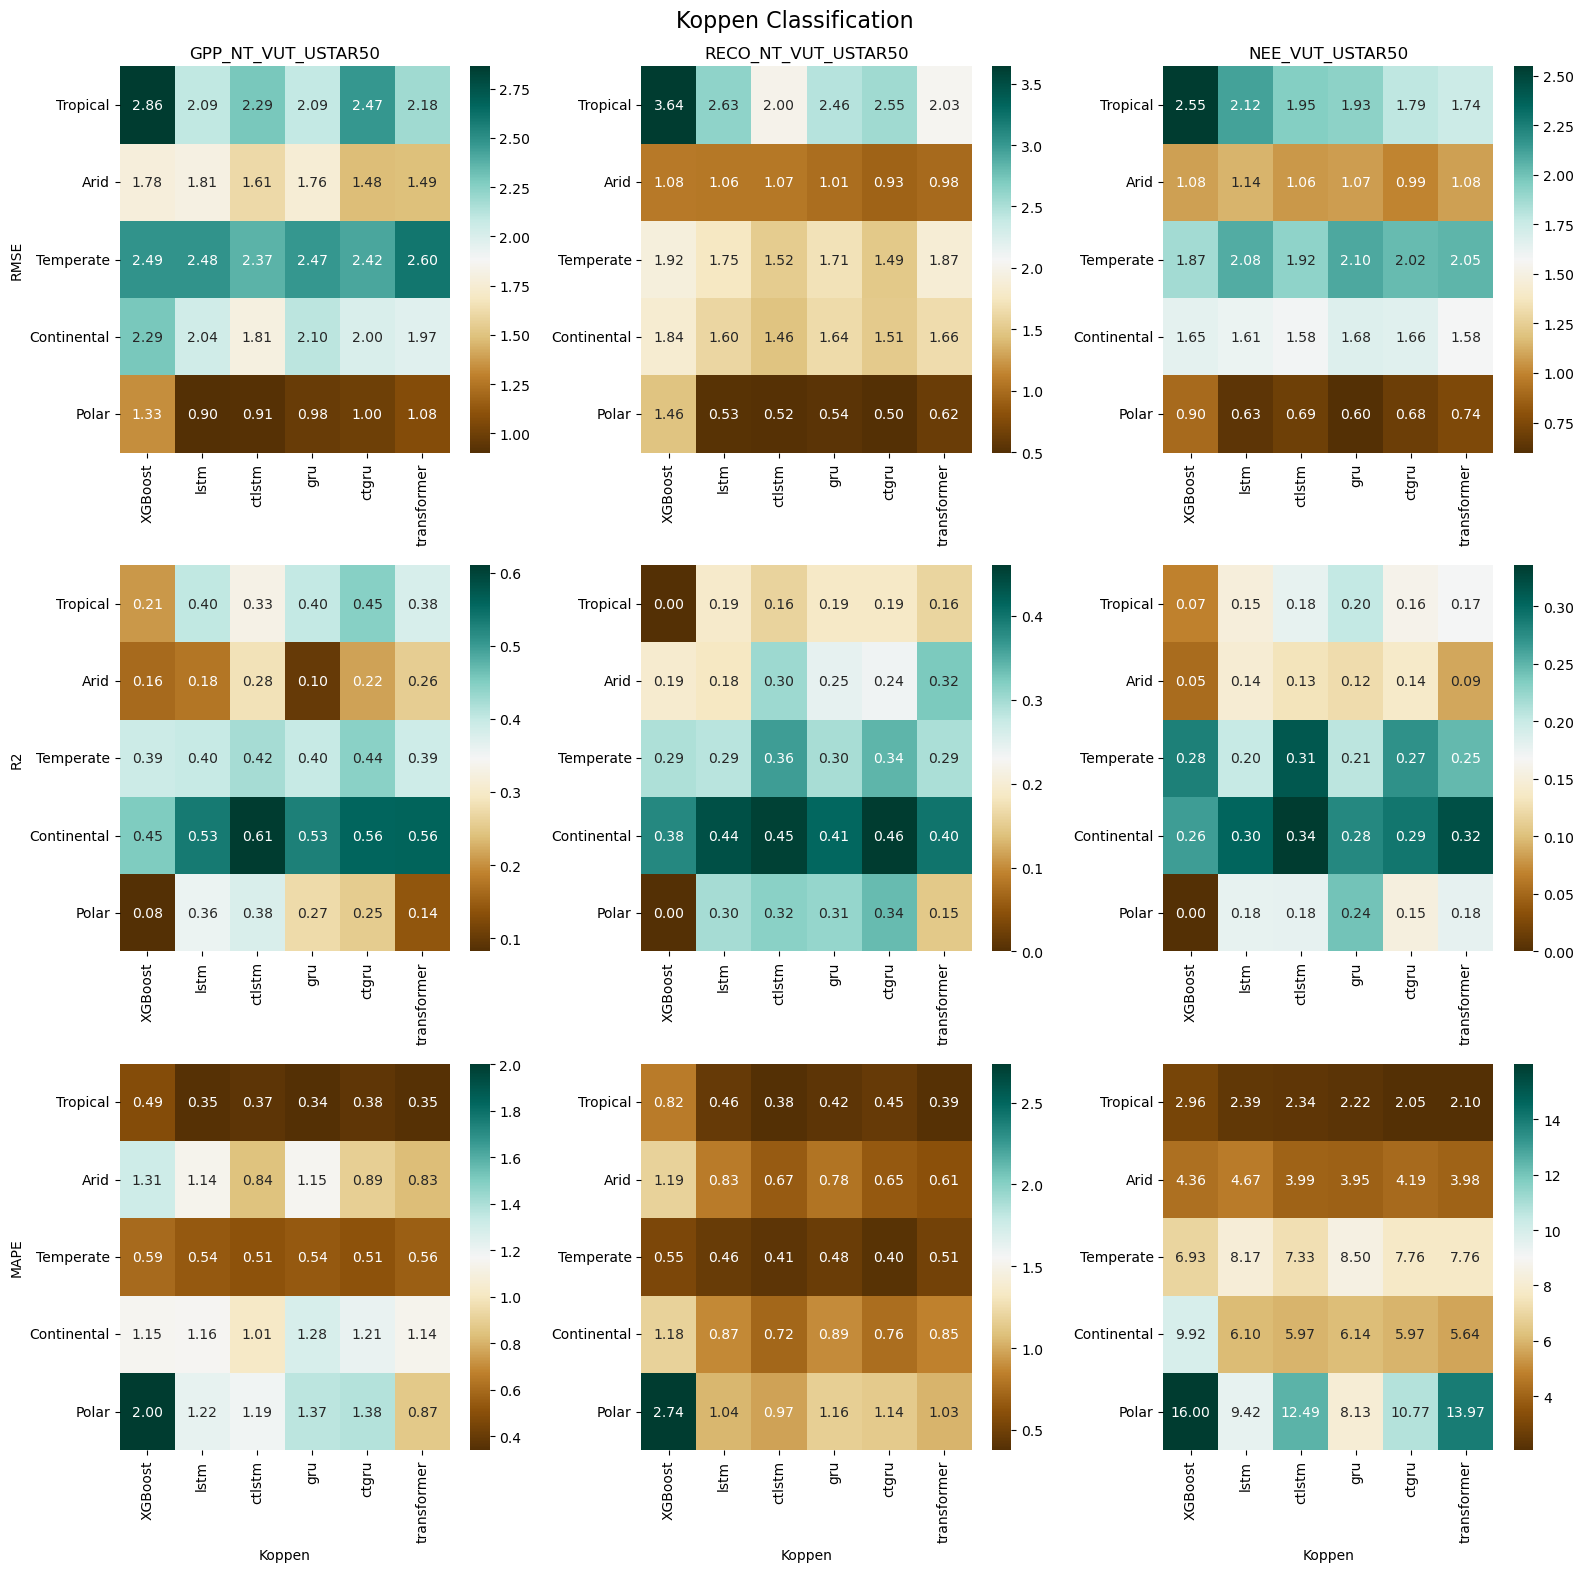

In [54]:
carbonbench.plot_heatmap(results, metrics, targets, classification='Koppen')